# **Defending the Edge: Evaluating OT Performance through Euclidean Measurements**

Read More in Paper: Defending the Edge: Evaluating OT Performance through Euclidean Measurements, https://docs.google.com/document/d/e/2PACX-1vRQXvtUFV5mFOr2nH9DgBU9rVTpTOjoElIT6JAr8RX4WWCNpKVBmsyzJz-d1fYfzz09fuwPuGC3u943/pub

github repo: https://github.com/autonomous019/NFL_Big_Data_Bowl_23

interactive website for QBI Ratings of Offensive Tackles: https://www.sonrai.a2hosted.com/oline/


This algorithm presents the results from aggregating and measuring Euclideans between the OT, Defensive Rusher and Quarterback, see equation 1 below.  There are six aspects of this evaluation of defending the edge. Each aspect has it's own algorithm managing the aggregation of the data and metrics for it. As seen by running this notebook the most important feature is that of length of play, see XGBoost section below and graphs before that section. QBI decreases as play length increases. 


![euclidean distance eq1](https://github.com/autonomous019/NFL_Big_Data_Bowl_23/blob/main/euclidean_distance1.png?raw=true) (1)


**Six Aspects of Evaluation:** 
* Quality of Block Index (QBI)
* Block Efficiency
* Block Momentum
* QB-DE Rating
* QB-DE Euclidean
* Straight Lines Euclideans



**-Frame Metrics Aggregation:** gathers relevant x,y coordinates of QB, OT, and DE or other rusher, measures the required euclideans and writes these values to the 'frame_metrics' table in the db. <a href="https://colab.research.google.com/drive/1nPgD7U6zJIHLGlonTdbDhq3ApHCcMFCM?usp=sharing">OT_Defending_The_Edge_Metric_Aggregation.ipynb</a> notebook file. Frame metrics is in the frame_metrics table in the db. 

**-QBI: Quality Block Index** is a rating system that penalizes based on the OT either being beaten or allowing himself or the rusher to enter three zones around the QB: buffer (1.5yds), danger (1.0yds) or sack (<.7yds).  It is based on a scale of 0-3 and comprises the primary metric for overall evaluation akin to PFF ranking of OL. These are strictly speaking position based or coordinate based ratings relative to the QB. Qualitative metrics are noted below I use two scales the QBI and the QBI+Style Metrics for evaluation. QBI data is held in the qbi_metrics table in the db. 

**-Block Metrics:** Is an evaluation of such things as Momentum, the euclidean relative to start and end of play during interface between blocker and defender, the QB-DE rating and euclidean scores. So that 3 metrics are created through the block metrics algo: qb-de rating (0,1), qb-de euclidean (float), momentum (0-100) and efficiency (0-100). QB-DE Euclidean is the measurement of whether the distance has increased from the start of itnerface to the end of the interface b/w the Blocker and Defender, increase in distance of defender from QB. Momentum is a measure of whether the blocker slows the rate of closure on the QB, measured on a frame by frame basis, score reflects total percentage of frames where momentum decreased during interface. Efficiency is a measure of whether a block is using arm block or close or control block style (i.e. body close to other body). <a href="https://colab.research.google.com/drive/1sGJMSsW4gVAAPmYzmH0JQ_VeP-vQbQOp?usp=sharing">QBI and Block Metric Algorithm Notebook</a> Block Metrics data is held in the block_metrics table in the db. 

**-Straight Lines Divergence:** Is an evaluation based on the concept of divergence of the defender from taking a straight line toward the quarterback, the ability of the blocker to deter the rusher from the shortest path toward his target, the QB, it is also based in measuring the euclidean. This euclidean is a measurement from the defenders position compared to his predicted position on a straight line to the QB from his previous position. The higher the euclidean distance the better the result, the higher one is off the straight line to the QB. Straight Lines is held in the lines_metrics table in the db. 

**-Play and Game Results:** This current algorithm, displays the results on a play by play basis and game basis and presents final QBI Rating, used for a more objective evaluation and the QBI+Style (QBI+) evaluation which includes measures that are a question of blocking styles and more subjective but informative on an individual level of blocking style. The final QBI+ is on a scale of 0-5.5 with QBI 3pts and QB-DE Rating (.5pts), QB-DE Euclidean (.5pts), Lines Rating (.5pts), Momentum (.5pts) and Efficiency (.5pts). Scores are 0 or .5 based on a threshold value, see paper linked below for more information. 

**-Plotting:** this algorithm plots plays for the front 5 vs front 5 or for individual defender against blocker with reference to the QB. I have generated a library of 1 on 1 Straight Line plots are available at https://drive.google.com/drive/folders/1J-aUNbdA4JR2sLAj_nBjyn6IsjmnwznF?usp=sharing (currenlty comprised of over 9000 plots listed by nflId and gameId for each rated play like the inline plot below).  The <a href="https://colab.research.google.com/drive/1C6aM5tLTj6luCqj951OdMvQhbH_IHBQE?usp=sharing">plotting notebook</a> contains the code for generating plots.  A sample animated <a href="https://github.com/autonomous019/NFL_Big_Data_Bowl_23/blob/main/2021090900_480%20(4).mp4?raw=true">front 5 vs front 5 plot</a>. 5-on-5 plots are set in the '5 on 5 Plots of Each Relevant Play' section of OT_Defending_The_Edge_Metric_Aggregation.ipynb notebook. 11 on 11 plots for rated players is at https://drive.google.com/drive/folders/14-k5qWk6vHiOI6HvlXo5uYEckzsrNK6z?usp=sharing


![2236](https://github.com/autonomous019/NFL_Big_Data_Bowl_23/blob/main/2236.png?raw=true)


**Time Length:** It should be noted that there is a limit on the evaluation of plays, I do not evaluate past 4 seconds of a play, this effects a minority of the plays as the large majority of plays are less then 4 seconds. 1 second equals 1 frame (10fps) in the NFL data. Also, one can see a distinction in the length of plays, one could query the database based on frames (i.e. where total_frames = 25, etc) to see results for a given time range in the plays and compare the scores for different time lengths. 

Read More in Paper: Defending the Edge: Evaluating OT Performance through Euclidean Measurements, https://docs.google.com/document/d/e/2PACX-1vRQXvtUFV5mFOr2nH9DgBU9rVTpTOjoElIT6JAr8RX4WWCNpKVBmsyzJz-d1fYfzz09fuwPuGC3u943/pub


github repo: https://github.com/autonomous019/NFL_Big_Data_Bowl_23

In [74]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import pyplot
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation
from functools import partial
from matplotlib.animation import writers
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
from xgboost import plot_importance
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import accuracy_score, classification_report
from hyperopt import hp
from hyperopt import fmin, tpe, STATUS_OK, STATUS_FAIL, Trials
from sklearn.model_selection import cross_val_score
import os



#%matplotlib inline

In [75]:
# Import from GoogleDrive
'''
from google.colab import drive
drive.mount('/content/gdrive')
os.chdir("//content/gdrive/MyDrive/nfl-big-data-bowl-2023/")

data_dir = "/content/gdrive/My Drive/nfl-big-data-bowl-2023/"
save_dir = "/content/gdrive/My Drive/nfl-big-data-bowl-2023/charts/"
lines_plots_dir = "/content/gdrive/My Drive/nfl-big-data-bowl-2023/lines_plots/"
#if on kaggle
#data_dir = "/kaggle/input/nfl-big-data-bowl-2023/"

'''
data_dir = "/kaggle/input/4seconds/40_databowl.db"

OUTPUT_DIR = './'
lines_plots_dir = OUTPUT_DIR
save_dir = OUTPUT_DIR






In [76]:
import sqlite3

con = sqlite3.connect(data_dir)



# **General Functions**

In [77]:
def get_scores(nfl_id):
    sql = "select * from qbi_metrics where blocker_id = "+str(nfl_id)
    qbi = pd.read_sql_query(sql, con)
    sql = "select * from block_metrics where blocker_id = "+str(nfl_id)
    block = pd.read_sql_query(sql, con)
    sql = "select * from lines_metrics where blocker_id = "+str(nfl_id)
    lines = pd.read_sql_query(sql, con)

    #with pd.option_context('display.max_rows', None,):
    #    display(query)
    return qbi,block,lines


def get_scores_by_game(nfl_id, game_id):
    sql = "select * from qbi_metrics where blocker_id = "+str(nfl_id)+" AND gameId = "+str(game_id)
    qbi = pd.read_sql_query(sql, con)
    sql = "select * from block_metrics where blocker_id = "+str(nfl_id)+" AND gameId = "+str(game_id)
    block = pd.read_sql_query(sql, con)
    sql = "select * from lines_metrics where blocker_id = "+str(nfl_id)+" AND gameId = "+str(game_id)
    lines = pd.read_sql_query(sql, con)

    #with pd.option_context('display.max_rows', None,):
    #    display(query)
    return qbi,block,lines

def get_scores_by_play(nfl_id, game_id, play_id):
    sql = "select * from qbi_metrics where blocker_id = "+str(nfl_id)+" AND gameId = "+str(game_id)+" AND playId = "+str(play_id)
    qbi = pd.read_sql_query(sql, con)
    sql = "select * from block_metrics where blocker_id = "+str(nfl_id)+" AND gameId = "+str(game_id)+" AND playId = "+str(play_id)

    block = pd.read_sql_query(sql, con)
    sql = "select * from lines_metrics where blocker_id = "+str(nfl_id)+" AND gameId = "+str(game_id)+" AND playId = "+str(play_id)

    lines = pd.read_sql_query(sql, con)

    #with pd.option_context('display.max_rows', None,):
    #    display(query)
    return qbi,block,lines


def get_metric_nflids(): 
    sql = """
           select DISTINCT(reference1_id) from frame_metrics where ref1_role IN ('LT', 'RT') 
    """ 
    query = pd.read_sql_query(sql, con)
    #print(query)
    return query

def get_game_ids(nfl_id):
  sql = """
           SELECT DISTINCT(gameId) from block_metrics where blocker_id = """+str(nfl_id)
  
  query = pd.read_sql_query(sql, con)
  #print(query)
  return query


def get_play_ids(nfl_id, game_id):
  sql = """
           SELECT DISTINCT(playId) from block_metrics where blocker_id = """+str(nfl_id)+""" AND gameId = """+str(game_id)
  
  query = pd.read_sql_query(sql, con)
  #print(query)
  return query








# **Ranking Functions**

# **Add Player Metrics to Plays Results Table Functions**

In [78]:
def Average(lst):
    return sum(lst) / len(lst)

def get_name(nfl_id):
  sql = "select displayName, weight, height from players where nflId = "+str(nfl_id)
  query = pd.read_sql_query(sql, con)
  display(query)
  return query

def get_combine_info(name):
  name = name.replace("'", " ")
  sql = "select * from combine where Name LIKE '%"+name+"%'"
  query = pd.read_sql_query(sql, con)
  display(query)
  return query

def qbi_sackarea(nfl_id):
  sql = "SELECT count(rush_sackarea) as rush_sackarea from qbi_metrics where blocker_id = " + str(nfl_id) + " AND rush_sackarea = 1"
  query = pd.read_sql_query(sql, con)
  return query

def qbi_dangerarea(nfl_id):
  sql = "SELECT count(rush_dangerarea) as rush_dangerarea from qbi_metrics where blocker_id = " + str(nfl_id) + " AND rush_dangerarea = 1"
  query = pd.read_sql_query(sql, con)
  return query

def qbi_bufferarea(nfl_id):
  sql = "SELECT count(rush_buffer) as rush_buffer from qbi_metrics where blocker_id = " + str(nfl_id) + " AND rush_buffer = 1"
  query = pd.read_sql_query(sql, con)
  return query

def qbi_beaten(nfl_id):
  sql = "SELECT count(beaten) as beaten from qbi_metrics where blocker_id = " + str(nfl_id) + " AND beaten = 1 and regained=0"
  query = pd.read_sql_query(sql, con)
  return query

def qbi_regained(nfl_id):
  sql = "SELECT count(regained) as regained from qbi_metrics where blocker_id = " + str(nfl_id) + " AND regained = 1 and beaten=1"
  query = pd.read_sql_query(sql, con)
  return query

def blocks_data(nfl_id):
  sql = "SELECT * from block_metrics where blocker_id = " + str(nfl_id)
  query = pd.read_sql_query(sql, con)
  return query

def get_qbi_level_cnt(nfl_id):
  sql = "SELECT DISTINCT(qbi_rating) as qbi_rating, count(playId) as playId from qbi_metrics where blocker_id = "+ str(nfl_id)+" GROUP BY qbi_rating"
  query = pd.read_sql_query(sql, con)
  return query

def get_leaderboard_nflids(): 
    sql = """
           select DISTINCT(blocker_id) from leaderboard where qbi_total_plays > 99 
    """ 
    query = pd.read_sql_query(sql, con)
    #print(query)
    return query

def get_leaderboard_info(nfl_id): 
    sql = """
           select * from leaderboard where qbi_total_plays > 99 AND blocker_id = """+str(nfl_id) 
     
    query = pd.read_sql_query(sql, con)
    #print(query)
    return query

def get_qbi_metrics(nfl_id, game_id, play_id):
  sql = "SELECT * from qbi_metrics where blocker_id = "+ str(nfl_id)+" AND gameId = "+str(game_id)+" AND playId = "+str(play_id) 
  query = pd.read_sql_query(sql, con)
  return query

def get_block_metrics(nfl_id, game_id, play_id):
  sql = "SELECT * from block_metrics where blocker_id = "+ str(nfl_id)+" AND gameId = "+str(game_id)+" AND playId = "+str(play_id) 
  query = pd.read_sql_query(sql, con)
  return query

def get_lines_metrics(nfl_id, game_id, play_id):
  sql = "SELECT * from lines_metrics where blocker_id = "+ str(nfl_id)+" AND gameId = "+str(game_id)+" AND playId = "+str(play_id) 
  query = pd.read_sql_query(sql, con)
  return query

def get_details(game_id, play_id):
  sql = "SELECT * from plays where gameId = "+str(game_id)+" AND playId = "+str(play_id) 
  query = pd.read_sql_query(sql, con)
  return query

def passer_for_play(nfl_id, game_id, play_id):

    sql = """
           select DISTINCT reference1_id from frame_metrics as fm WHERE fm.reference2_id = """ + str(nfl_id) + """ 
           AND fm.playId = """ + str(play_id) + """  
           AND fm.gameId = """ + str(game_id) + """
    """  
    query = pd.read_sql_query(sql, con)
    return query

def defender_for_play(nfl_id, game_id, play_id):

    sql = """
           select DISTINCT reference2_id from frame_metrics as fm WHERE fm.reference1_id = """ + str(nfl_id) + """ 
           AND fm.playId = """ + str(play_id) + """  
           AND fm.gameId = """ + str(game_id) + """
    """  
    query = pd.read_sql_query(sql, con)
    return query


# Python code to merge dict using update() method
def Merge(dict1, dict2):
    return(dict2.update(dict1))

def add_play_result(data):
  cursor = con.cursor()

  print(data)
  #c.execute("INSERT INTO users VALUES (:id, :name, :dob)", user1) 

  sql = """INSERT INTO `play_results` VALUES (:blocker_id, :defender_id, :name, :weight, :height, :qbi_rating, :t_sack, :t_danger, :t_buffer, :t_block_sack, :t_block_danger, 
  :t_block_buffer, :t_regained, :t_beaten, :int_cnt, :cntrl_cnt, :total_frames, :efficiency, 
  :momentum, :qb_de_eucl_avg, :qb_de_rating, :lines_score, :gameId, :playId)""" 

  
  #print(sql)
  #cursor.execute(sql)
  cursor.execute(sql, data)
  con.commit()


def get_ids():
    sql = """
           select DISTINCT(blocker_id) as block_id, COUNT(playId) as play_cnt from block_metrics  GROUP BY block_id
    """
    query = pd.read_sql_query(sql, con)
    return query

def get_name(nfl_id):
  sql = "select displayName as name, weight, height from players where nflId = "+str(nfl_id)
  query = pd.read_sql_query(sql, con)
  display(query)
  return query

def get_combine_info(name):
  name = name.replace("'", " ")
  sql = "select * from combine where Name LIKE '%"+name+"%'"
  query = pd.read_sql_query(sql, con)
  display(query)
  return query



############################################### END FUNCTIONS ###########################



# **Aggregate Player Results Driver**

In [79]:

#uncomment to aggregate player results to play_results table in db. 
'''

nflids = get_ids()
#nfl_ids = nflids[['block_id']]
nfl_ids = nflids
print(nfl_ids)
nflids_len = len(nfl_ids)
qbi_mis = []
games_list = []

for c,r in nfl_ids.iterrows():
  #if c > 0:
  #  break
  
  nfl_id = r['block_id']
  min_cnt = r['play_cnt']
  if min_cnt < 99:
        continue
  
  #get_info = get_leaderboard_info(nfl_id)
  get_info = get_name(nfl_id)
  name = get_info['displayName'].values
  for n in name:
    name = n
  name = str(name)
  print(name)

  weight = get_info['weight'].values
  for n in weight:
    weight = n
  
  height = get_info['height'].values
  for n in height:
    height = n

  #get games
  games = get_game_ids(nfl_id)
  for c,g in games.iterrows():

    game_id = g['gameId'] 
    games_list.append(game_id) 
    plays = get_play_ids(nfl_id, game_id)
    for c,p in plays.iterrows():
      play_result = {}
      play_id = p['playId']
      print(name, nfl_id, game_id, play_id)
      #get info from plays
      details = get_details(game_id, play_id)
      qbi = get_qbi_metrics(nfl_id, game_id, play_id)
      block = get_block_metrics(nfl_id, game_id, play_id)
      lines = get_lines_metrics(nfl_id, game_id, play_id)

      #QBI 
      blocker_id = qbi['blocker_id'][0]
      defender_id = qbi['defender_id'][0]
      qbi_rating = qbi['qbi_rating'][0]
      t_block_sack = qbi['rush_sackarea'][0]
      t_block_danger = qbi['block_dangerarea'][0]
      t_block_buffer = qbi['block_buffer'][0]
      t_sack = qbi['rush_sackarea'][0]
      t_danger = qbi['rush_dangerarea'][0]
      t_buffer = qbi['rush_buffer'][0]     
      t_regained = qbi['regained'][0]
      t_beaten = qbi['beaten'][0] - t_regained
      #qbi_data = dict({ 'blocker_id': blocker_id, 'defender_id':defender_id, 'qbi_rating': qbi_rating, 't_sack': t_sack, 't_danger': t_danger, 't_buffer': t_buffer, 't_block_sack': t_block_sack, 't_block_danger': t_block_danger, 't_block_buffer': t_block_buffer, 't_regained': t_regained, 't_beaten': t_beaten})
      #print(qbi_data)
      
      #Blocks


      for c,b in block.iterrows():
        int_cnt = b['interface_cnt']
        cntrl_cnt = b['control_cnt']
        total_frames = b['total_frames']
        effic = cntrl_cnt/int_cnt
        momentum = b['momentum_rating']
        qb_de_eucl_avg = b['qb_de_eucl_avg']
        qb_de_rating = b['qb_de_rating']
        #block_data = ({'int_cnt':int_cnt, 'cntrl_cnt': cntrl_cnt, 'total_frames': total_frames, 'efficiency':effic, 'momentum':momentum, 'qb_de_eucl_avg':qb_de_eucl_avg, 'qb_de_rating':qb_de_rating})
        #print(block_data)

        #Lines
        if len(lines) == 0:
          lines_score = 0
        else:
          lines_score = lines['score'][0]

        #lines_data = ({ 'lines_score': lines_score})
        #print(lines_data)
        data = ({ 'blocker_id': int(blocker_id), 'defender_id':int(defender_id), 'name': name, 'weight':int(weight), 'height':height, 'qbi_rating': qbi_rating, 't_sack': int(t_sack), 
                 't_danger': int(t_danger), 't_buffer': int(t_buffer), 
                 't_block_sack': int(t_block_sack), 't_block_danger': int(t_block_danger), 't_block_buffer': int(t_block_buffer), 't_regained': int(t_regained), 
                 't_beaten': int(t_beaten),
                 'int_cnt':int_cnt, 'cntrl_cnt': cntrl_cnt, 'total_frames': total_frames, 'efficiency':effic, 'momentum':momentum, 
                 'qb_de_eucl_avg':qb_de_eucl_avg, 'qb_de_rating':qb_de_rating, 'lines_score': lines_score, 'gameId':int(game_id), 'playId': int(play_id)
                 })
        
        print(data)
        
        
        print()
        print()
        print()
        
        # ADD PLAY RESULT TO THE DATABASE
        #write play results, uncomment below to add to db
        #add_play_result(data)


    print("_______________________")
    print()
  #write game results

print(qbi_mis)
'''

'\n\nnflids = get_ids()\n#nfl_ids = nflids[[\'block_id\']]\nnfl_ids = nflids\nprint(nfl_ids)\nnflids_len = len(nfl_ids)\nqbi_mis = []\ngames_list = []\n\nfor c,r in nfl_ids.iterrows():\n  #if c > 0:\n  #  break\n  \n  nfl_id = r[\'block_id\']\n  min_cnt = r[\'play_cnt\']\n  if min_cnt < 99:\n        continue\n  \n  #get_info = get_leaderboard_info(nfl_id)\n  get_info = get_name(nfl_id)\n  name = get_info[\'displayName\'].values\n  for n in name:\n    name = n\n  name = str(name)\n  print(name)\n\n  weight = get_info[\'weight\'].values\n  for n in weight:\n    weight = n\n  \n  height = get_info[\'height\'].values\n  for n in height:\n    height = n\n\n  #get games\n  games = get_game_ids(nfl_id)\n  for c,g in games.iterrows():\n\n    game_id = g[\'gameId\'] \n    games_list.append(game_id) \n    plays = get_play_ids(nfl_id, game_id)\n    for c,p in plays.iterrows():\n      play_result = {}\n      play_id = p[\'playId\']\n      print(name, nfl_id, game_id, play_id)\n      #get info from

# **Generate Results by Game Functions**

In [80]:
def get_results(nfl_id): 
    sql = """
           select * from play_results where blocker_id = """+str(nfl_id) 
     
    query = pd.read_sql_query(sql, con)
    #print(query)
    return query

def get_player_games(nfl_id): 
    sql = """
           select DISTINCT(gameId) from play_results where blocker_id = """+str(nfl_id) 
     
    query = pd.read_sql_query(sql, con)
    #print(query)
    return query

def get_results_by_game(nfl_id, game_id): 
    sql = """
           select * from play_results where blocker_id = """+str(nfl_id)+""" 
           AND gameId = """+str(game_id)
     
    query = pd.read_sql_query(sql, con)
    #print(query)
    return query

def get_play_info(game_id, play_id): 
    sql = """
           select * from plays where gameId = """+str(game_id)+ """ 
           AND playId = """+str(play_id) 
     
    query = pd.read_sql_query(sql, con)
    #print(query)
    return query

def get_defender_info(nfl_id): 
    sql = """
           select * from players where nflId = """+str(nfl_id)
     
    query = pd.read_sql_query(sql, con)
    #print(query)
    return query

def get_defender_role(nfl_id, game_id, play_id): 
    sql = """
           select ref2_role from frame_metrics where reference2_id = """+str(nfl_id)+""" 
           AND gameId = """+str(game_id)+""" AND playId = """ +str(play_id)
     
    query = pd.read_sql_query(sql, con)
    #print(query)
    return query

def add_game_result(data):
  cursor = con.cursor()

  print(data)


  sql = """
           INSERT INTO `game_results` VALUES (:blocker_id, :gameId, :total_plays, :t_qbi, :t_ln, :t_qbde_rating, :t_qbde_eucl, :t_effic, :t_momentum, :t_scores, 
:c_cnt, :i_cnt, :c_qbi, :i_qbi, :c_ln, :i_ln, :c_qbde_rating, :i_qbde_rating, :c_qbde_eucl, :i_qbde_eucl, :c_effic, :i_effic, 
:c_momentum, :i_momentum, :c_scores, :i_scores, :success_rate)
""" 

  
  #print(sql)
  #cursor.execute(sql)
  cursor.execute(sql, data)
  con.commit()
  
def update_play_results(blocker_id, game_id, play_id, field, field_value):
  cursor = con.cursor()
  #play_total
  sql = "UPDATE play_results SET "+field+" = "+str(field_value)+" WHERE blocker_id = "+ str(blocker_id)+" AND gameId = "+str(game_id)+" AND playId = "+str(play_id)
  print(sql)
  print()   
  # Execute the query
  cursor.execute(sql)
  # the connection is not autocommited by default. So we must commit to save our changes.
  con.commit()




# **Display Results by Play, with Game Results**

The following will display the results of several metrics, such as QBI, Qb-DE-rating, Qb-DE-euclidean, Straight Lines Ratings, and Momentum. Results are displayed for each play, as well as for each game. Data is also presented to compare along Pass completed vs incompleted results for the previously mentioned metrics. 



In [81]:
#uncomment this cell if you want to see a report of results play by play for each blocker

'''


#update_play_results() needs uncommented and add_game_results() to write to db. 
nflids = nflids = get_ids()
#nfl_ids = nflids[['block_id']]
nfl_ids = nflids

nflids_len = len(nfl_ids)
games_list = []
  
for c,r in nfl_ids.iterrows():
  
  
  nfl_id = r['block_id']
  min_cnt = r['play_cnt']
  if min_cnt < 99:
    continue


  games = get_player_games(nfl_id)

  total_games = len(games)
  for c,g in games.iterrows():
    game_id = g['gameId']
    print()
    print()
    print("###########################################")
    print("#########", nfl_id,"  ", game_id, "#########")
    print("###########################################")
    print()
    print(c)
    print(game_id)
    print(nfl_id)
    game_results = get_results_by_game(nfl_id, game_id)
    qbi_game_avg = game_results[['qbi_rating']].mean()
    qbi_game_avg = qbi_game_avg.values
    for n in qbi_game_avg:
      qbi_avg = n
    print("QBI AVG FOR GAME: ", qbi_avg)

    qbi_list = []
    completed_qbi_list = []
    incompleted_qbi_list = []
    completed_lines_list = []
    incompleted_lines_list = []
    completed_qbde_rating_list = []
    incompleted_qbde_rating_list = []
    completed_qbde_eucl_list = []
    incompleted_qbde_eucl_list = []
    completed_efficiency_list = []
    incompleted_efficiency_list = []
    completed_momentum_list = []
    incompleted_momentum_list = []
    completed_play_scores = []
    incompleted_play_scores = []

    play_scores = []
    qbi_list = []
    lines_list = []
    qbde_rating_list = []
    qbde_eucl_list = []
    efficiency_list = []
    momentum_list = []


    for c,r in game_results.iterrows():

      blocker_id = r['blocker_id']
      name = r['name']
      game_id = r['gameId']
      play_id = r['playId']
      qbi_avg = r['qbi_rating']

      qb_de_eucl_avg = r['qb_de_eucl_avg']
      #if qb_de_eucl_avg > .4 add .50 to score dictionary
      if qb_de_eucl_avg >= 4.0:
        qb_de_eucl_score = .5
      else:
        qb_de_eucl_score = 0

      qb_de_rating = r['qb_de_rating']
      #if qb_de_eucl_rating = 1 add .50 to score dictionary
      if qb_de_rating == 1:
        qb_de_rating_score = .5
      else:
        qb_de_rating_score = 0
      
      d_sack = r['t_sack']
      d_danger = r['t_danger']
      d_buffer = r['t_buffer']
      b_sack = r['t_block_sack']
      b_danger = r['t_block_danger']
      b_buffer = r['t_block_buffer']
      regained = r['t_regained']
      beaten = r['t_beaten']
      momentum = r['momentum']
      #if momentum > .5 add .50 to score dictionary
      if momentum >= .5:
        momentum_score = .5
      else:
        momentum_score = 0

      efficiency = r['efficiency']
      #if momentum > .25 add .50 to score dictionary
      if efficiency >= .25:
        efficiency_score = .5
      else:
        efficiency_score = 0

      lines_score = r['lines_score']
      #if lines_score > .3 add .50 to score dictionary
      if lines_score >= .3:
        lines_score_score = .5
      else:
        lines_score_score = 0
      
      defender_id = r['defender_id']
      defender_name = get_defender_info(defender_id)
      for c,p in defender_name.iterrows():
        def_name = p['displayName']
      defender_role = get_defender_role(defender_id, game_id, play_id)
      play_score = qbi_avg + qb_de_eucl_score + qb_de_rating_score + momentum_score + efficiency_score + lines_score_score
      for c,p in defender_role.iterrows():
        def_role = p['ref2_role']
      int_cnt = r['int_cnt']
      cntrl_cnt = r['cntrl_cnt']
      total_frames = r['total_frames']
      play_info = get_play_info(game_id, play_id)
      for c,p in play_info.iterrows():
        desc = p['playDescription']
        complete = p['passResult']
        play_scores.append(play_score)
        qbi_list.append(qbi_avg)
        lines_list.append(lines_score)
        qbde_rating_list.append(qb_de_rating)
        qbde_eucl_list.append(qb_de_eucl_avg)
        efficiency_list.append(efficiency)
        momentum_list.append(momentum)

        if complete == 'C':
          completed_qbi_list.append(qbi_avg)
          completed_lines_list.append(lines_score)
          completed_qbde_rating_list.append(qb_de_rating)
          completed_qbde_eucl_list.append(qb_de_eucl_avg)
          completed_efficiency_list.append(efficiency)
          completed_play_scores.append(play_score)
          completed_momentum_list.append(momentum)

        else:
          incompleted_qbi_list.append(qbi_avg)
          incompleted_lines_list.append(lines_score)
          incompleted_qbde_rating_list.append(qb_de_rating)
          incompleted_qbde_eucl_list.append(qb_de_eucl_avg)
          incompleted_efficiency_list.append(efficiency)
          incompleted_play_scores.append(play_score)
          incompleted_momentum_list.append(momentum)
      
      print()
      print(play_id, " -- ", name, "QBI: ", qbi_avg, " ln: ", lines_score, " qb-de eucl: ", qb_de_eucl_avg, "qb-de rating: ", qb_de_rating)
      print("qb eucl score", qb_de_eucl_score, " qb_de_rating score: ", qb_de_rating_score, " momentum score: ", momentum_score, " effic scr: ", efficiency_score, " ln scr: ", lines_score_score)
      print("Play Score: ", play_score)
      print("        ", "effic: ", efficiency, " mom: ", momentum)
      print(desc)
      print("Defender: ",def_name, " position: ", def_role)
      print("+++++++++++++++++++++++++++++++++++++++++++++++++++++++++")    
      #UNCOMMENT to update play_results
      #update_play_results(blocker_id, game_id, play_id, 'play_total', play_score)

    print()
    
    print("completed qbi avg: ", Average(completed_qbi_list), len(completed_qbi_list))
    print("incompleted qbi avg: ", Average(incompleted_qbi_list), len(incompleted_qbi_list))
    print("completed lines avg: ", Average(completed_lines_list), len(completed_lines_list))
    print("incompleted lines avg: ", Average(incompleted_lines_list), len(incompleted_lines_list))
    print("completed qb-de eucl avg: ", Average(completed_qbde_rating_list), len(completed_qbde_rating_list))
    print("incompleted qb-de eucl avg: ", Average(incompleted_qbde_rating_list), len(incompleted_qbde_rating_list))
    print("completed effic avg: ", Average(completed_efficiency_list), len(completed_efficiency_list))
    print("incompleted effic avg: ", Average(incompleted_efficiency_list), len(incompleted_efficiency_list))
    print("completed momentum avg: ", Average(completed_momentum_list), len(completed_momentum_list))
    print("incompleted momentum avg: ", Average(incompleted_momentum_list), len(incompleted_momentum_list))
    print("completed play score avg: ", Average(completed_play_scores), len(completed_play_scores))
    print("incompleted play score avg: ", Average(incompleted_play_scores), len(incompleted_play_scores))
    print()
    success_plays = game_results[game_results['qbi_rating'] > 2.74]
    success_rate = len(success_plays) / len(game_results)
    print("Success plays: ", success_rate)

    c_qbi = Average(completed_qbi_list)
    i_qbi = Average(incompleted_qbi_list)
    c_ln = Average(completed_lines_list)
    i_ln = Average(incompleted_lines_list)
    c_qbde_rating = Average(completed_qbde_rating_list)
    i_qbde_rating = Average(incompleted_qbde_rating_list)
    c_qbde_eucl = Average(completed_qbde_eucl_list)
    i_qbde_eucl = Average(incompleted_qbde_eucl_list)
    c_effic = Average(completed_efficiency_list)
    i_effic = Average(incompleted_efficiency_list)
    c_momentum = Average(completed_momentum_list)
    i_momentum = Average(incompleted_momentum_list)
    c_scores = Average(completed_play_scores)
    i_scores = Average(incompleted_play_scores)
    #total scores
    t_qbi = Average(qbi_list)
    t_ln = Average(lines_list)
    t_qbde_rating = Average(qbde_rating_list)
    t_qbde_eucl = Average(qbde_eucl_list)
    t_effic = Average(efficiency_list)
    t_momentum = Average(momentum_list)
    t_scores = Average(play_scores)
    c_cnt = len(completed_qbi_list) 
    i_cnt = len(incompleted_qbi_list) 
    total_plays = len(play_scores)
    print("game results: ", t_qbi, t_ln, t_qbde_rating, t_qbde_eucl, t_effic, t_momentum, t_scores)    

    play_data = ({ 'blocker_id': int(blocker_id), 'gameId': int(game_id), 'total_plays': int(total_plays), 't_qbi': t_qbi, 't_ln':t_ln, 't_qbde_rating':t_qbde_rating,
               't_qbde_eucl': t_qbde_eucl, 't_effic':t_effic, 't_momentum':t_momentum, 't_scores':t_scores, 'c_cnt':int(c_cnt), 'i_cnt':int(i_cnt), 'c_qbi':c_qbi, 'i_qbi': i_qbi,
               'c_ln': c_ln, 'i_ln':i_ln, 'c_qbde_rating':c_qbde_rating, 'i_qbde_rating':i_qbde_rating, 'c_qbde_eucl':c_qbde_eucl, 'i_qbde_eucl':i_qbde_eucl,
               'c_effic':c_effic, 'i_effic':i_effic, 'c_momentum':c_momentum, 'i_momentum':i_momentum, 'c_scores':c_scores, 'i_scores':i_scores, 'success_rate':success_rate 
                 })

    #ADD GAME RESULTS TO DB
    #uncomment add_game_result() to add to database
    #dont forget to uncomment update_play_result() above too
    #add_game_result(play_data)
    


    #write game results to weekly_results table
    
    print("------------------")
    print()
  print("Total games: ", total_games)
  print()
  print()
  print("=============================")

  print()
  print()
  print("#########################################################")
  print("+++++++++++++++++++++++++++++++++++++++++++++++++++++++++")
  print("                    NEXT PLAYER                          ")
  print("+++++++++++++++++++++++++++++++++++++++++++++++++++++++++")
  print("#########################################################")
  print()
  print()

'''

'\n\n\n#update_play_results() needs uncommented and add_game_results() to write to db. \nnflids = nflids = get_ids()\n#nfl_ids = nflids[[\'block_id\']]\nnfl_ids = nflids\n\nnflids_len = len(nfl_ids)\ngames_list = []\n  \nfor c,r in nfl_ids.iterrows():\n  \n  \n  nfl_id = r[\'block_id\']\n  min_cnt = r[\'play_cnt\']\n  if min_cnt < 99:\n    continue\n\n\n  games = get_player_games(nfl_id)\n\n  total_games = len(games)\n  for c,g in games.iterrows():\n    game_id = g[\'gameId\']\n    print()\n    print()\n    print("###########################################")\n    print("#########", nfl_id,"  ", game_id, "#########")\n    print("###########################################")\n    print()\n    print(c)\n    print(game_id)\n    print(nfl_id)\n    game_results = get_results_by_game(nfl_id, game_id)\n    qbi_game_avg = game_results[[\'qbi_rating\']].mean()\n    qbi_game_avg = qbi_game_avg.values\n    for n in qbi_game_avg:\n      qbi_avg = n\n    print("QBI AVG FOR GAME: ", qbi_avg)\n\n    

# # **Display Positional Based Quantitative Results based on QBI**

This result is used to rank players by more objective criteria

In [82]:
sql = "select p.displayName, gr.blocker_id, AVG(gr.t_qbi) from game_results as gr, players as p WHERE gr.blocker_id = p.nflId GROUP BY blocker_id ORDER BY AVG(gr.t_qbi) DESC"
#sql = "select rowid, blocker_id from block_metrics"
query = pd.read_sql_query(sql, con)
print(len(query))
with pd.option_context('display.max_rows', None,):
  display(query)

50


,displayName,blocker_id,AVG(gr.t_qbi)
0,Andrew Whitworth,30869,2.934584
1,Tristan Wirfs,52421,2.934543
2,Andrew Thomas,52412,2.926037
3,Charles Leno,41475,2.921698
4,Trent Williams,35443,2.920399
5,Rob Havenstein,42400,2.919004
6,Riley Reiff,38553,2.915470
7,Justin Herron,52603,2.907897
8,Donovan Smith,42377,2.902957
9,Brian O'Neill,46131,2.893011


# **Display Results: QBI plus Quality Scores** 

These results are more subjective and include more qualitative values that may vary from blocker to blocker but do not directly correlate to success or failure in blocking on a given play. 

In [83]:

sql = "select p.displayName, gr.blocker_id, AVG(gr.t_scores) from game_results as gr, players as p WHERE gr.blocker_id = p.nflId GROUP BY blocker_id ORDER BY AVG(gr.t_scores) DESC"
#sql = "select rowid, blocker_id from block_metrics"
query = pd.read_sql_query(sql, con)
print(len(query))
with pd.option_context('display.max_rows', None,):
  display(query)



50


,displayName,blocker_id,AVG(gr.t_scores)
0,Rashawn Slater,53442,4.450451
1,D.J. Humphries,42367,4.441154
2,Jake Matthews,41232,4.437994
3,Kolton Miller,46084,4.419039
4,Tristan Wirfs,52421,4.405847
5,Riley Reiff,38553,4.393164
6,Geron Christian,46143,4.390741
7,Rob Havenstein,42400,4.368114
8,Trent Williams,35443,4.353522
9,Andrew Whitworth,30869,4.344626


In [84]:


sql = "select AVG(qbi_rating) as cost, gameId, * from play_results WHERE total_frames < 20 GROUP BY gameId"
# select AVG(gr.t_qbi) as cost, COUNT(pr.playId), pr.total_frames, gr.* from game_results as gr, play_results as pr where gr.gameId = pr.gameId AND pr.total_frames >= 35 GROUP BY gr.gameId ORDER BY cost DESC 
ten_to_twenty = pd.read_sql_query(sql, con)
print("Play length < 2.0",len(ten_to_twenty))
#with pd.option_context('display.max_rows', None,):
#  display(ten_to_twenty)

sql = "select AVG(qbi_rating) as cost, gameId, * from play_results WHERE total_frames >= 20 AND total_frames <= 25 GROUP BY gameId"
# select AVG(gr.t_qbi) as cost, COUNT(pr.playId), pr.total_frames, gr.* from game_results as gr, play_results as pr where gr.gameId = pr.gameId AND pr.total_frames >= 35 GROUP BY gr.gameId ORDER BY cost DESC 
twenty_to_twentyfive = pd.read_sql_query(sql, con)
print("Play length < 2.0",len(twenty_to_twentyfive))
#with pd.option_context('display.max_rows', None,):
#  display(ten_to_twenty)

sql = "select AVG(qbi_rating) as cost, gameId, * from play_results WHERE total_frames >= 25 AND total_frames <= 30 GROUP BY gameId"
# select AVG(gr.t_qbi) as cost, COUNT(pr.playId), pr.total_frames, gr.* from game_results as gr, play_results as pr where gr.gameId = pr.gameId AND pr.total_frames >= 35 GROUP BY gr.gameId ORDER BY cost DESC 
twentyfive_to_thirty = pd.read_sql_query(sql, con)
print("Play length < 2.0",len(twentyfive_to_thirty))
#with pd.option_context('display.max_rows', None,):
#  display(ten_to_twenty)

sql = "select AVG(qbi_rating) as cost, gameId, * from play_results WHERE total_frames >= 30 AND total_frames <= 35 GROUP BY gameId"
# select AVG(gr.t_qbi) as cost, COUNT(pr.playId), pr.total_frames, gr.* from game_results as gr, play_results as pr where gr.gameId = pr.gameId AND pr.total_frames >= 35 GROUP BY gr.gameId ORDER BY cost DESC 
thirty_to_thirtyfive = pd.read_sql_query(sql, con)
print("Play length >2.5 < 3.0",len(thirty_to_thirtyfive))
#with pd.option_context('display.max_rows', None,):
#  display(ten_to_twenty)


sql = "select AVG(qbi_rating) as cost, gameId, * from play_results WHERE total_frames >= 35 AND total_frames <= 40.0 GROUP BY gameId"
# select AVG(gr.t_qbi) as cost, COUNT(pr.playId), pr.total_frames, gr.* from game_results as gr, play_results as pr where gr.gameId = pr.gameId AND pr.total_frames >= 35 GROUP BY gr.gameId ORDER BY cost DESC 
thirtyfive_to_forty = pd.read_sql_query(sql, con)
print("Play length >=3.0 =< 3.5",len(thirtyfive_to_forty))
#with pd.option_context('display.max_rows', None,):
#  display(thirtyfive_to_forty)


# select AVG(qbi_rating) from play_results WHERE total_frames < 20
# select AVG(qbi_rating) from play_results WHERE total_frames >= 20 AND total_frames < 25
# ten_to_twenty thirtyfive_to_forty

Play length < 2.0 113
Play length < 2.0 120
Play length < 2.0 120
Play length >2.5 < 3.0 120
Play length >=3.0 =< 3.5 120


113


/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


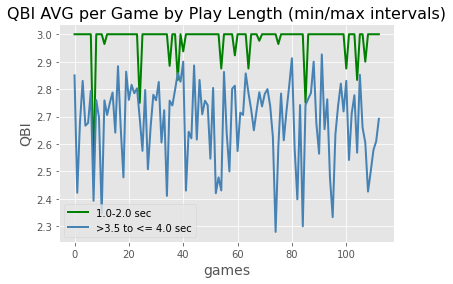

<Figure size 864x864 with 0 Axes>

In [85]:
#ten_to_twenty thirtyfive_to_forty
df = ten_to_twenty
df2 = thirtyfive_to_forty
#see if this needs renamed to avoid breaking original dataframe sql query return
ten_to_twenty_df = df[['cost', 'gameId']]
thirtyfive_to_forty_df = df2[['cost', 'gameId']]

#with pd.option_context('display.max_rows', None,):
#  display(ten_to_twenty)

#with pd.option_context('display.max_rows', None,):
#  display(thirtyfive_to_forty)
 
ten_to_twenty_df.rename(columns = {'cost':'ten_cost', 'gameId':'ten_gameId'}, inplace = True)
thirtyfive_to_forty_df.rename(columns = {'cost':'thirtyfive_cost', 'gameId':'thirtyfive_gameId'}, inplace = True)


#merge dataframes for blocker, qb, and defender
metrics_concat = pd.concat([ten_to_twenty_df, thirtyfive_to_forty_df], axis=1)
metrics_concat = metrics_concat.dropna()

print(len(metrics_concat))

#with pd.option_context('display.max_rows', None,):
#  display(metrics_concat)

df = metrics_concat

plt.plot(df['ten_cost'], color='green', linewidth=2)
plt.plot(df['thirtyfive_cost'], color='steelblue', linewidth=2)
#plt.plot(df['sales'], color='purple', linestyle='dashed')
plt.style.use('ggplot')
#add legend
plt.legend()
#add axis labels and a title
plt.ylabel('QBI', fontsize=14)
plt.xlabel('games', fontsize=14)
plt.title('QBI AVG per Game by Play Length (min/max intervals)', fontsize=16)
legend_drawn_flag = True
plt.legend(["1.0-2.0 sec", ">3.5 to <= 4.0 sec"], loc=0, frameon=legend_drawn_flag)
plt.figure(figsize=(12, 12))

#display plot
plt.savefig('time_span_2bins.png')
#plt.show()




/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


113


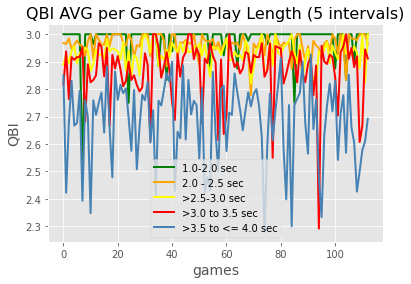

<Figure size 864x864 with 0 Axes>

In [86]:
#ten_to_twenty thirtyfive_to_forty
df = ten_to_twenty
df2 = thirtyfive_to_forty
df3 = twentyfive_to_thirty
df4 = thirty_to_thirtyfive
df5 = twenty_to_twentyfive
#see if this needs renamed to avoid breaking original dataframe sql query return
ten_to_twenty_df = df[['cost', 'gameId']]
thirtyfive_to_forty_df = df2[['cost', 'gameId']]
twentyfive_to_thirty_df = df3[['cost', 'gameId']]
thirty_to_thirtyfive_df = df4[['cost', 'gameId']]
twenty_to_twentyfive_df = df5[['cost', 'gameId']]

#with pd.option_context('display.max_rows', None,):
#  display(ten_to_twenty)

#with pd.option_context('display.max_rows', None,):
#  display(thirtyfive_to_forty)
 
ten_to_twenty_df.rename(columns = {'cost':'ten_cost', 'gameId':'ten_gameId'}, inplace = True)
thirtyfive_to_forty_df.rename(columns = {'cost':'thirtyfive_cost', 'gameId':'thirtyfive_gameId'}, inplace = True)
twenty_to_twentyfive_df.rename(columns = {'cost':'twenty_cost', 'gameId':'twenty_gameId'}, inplace = True)
twentyfive_to_thirty_df.rename(columns = {'cost':'twentyfive_cost', 'gameId':'twentyfive_gameId'}, inplace = True)
thirty_to_thirtyfive_df.rename(columns = {'cost':'thirty_cost', 'gameId':'thirty_gameId'}, inplace = True)


#merge dataframes for blocker, qb, and defender
metrics_concat = pd.concat([ten_to_twenty_df, twenty_to_twentyfive_df, twentyfive_to_thirty_df, thirty_to_thirtyfive_df, thirtyfive_to_forty_df], axis=1)
metrics_concat = metrics_concat.dropna()

print(len(metrics_concat))

#with pd.option_context('display.max_rows', None,)
#  display(metrics_concat)
metrics_concat.head

df_m = metrics_concat

plt.plot(df_m['ten_cost'], color='green', linewidth=2)
plt.plot(df_m['twenty_cost'], color='orange', linewidth=2)
plt.plot(df_m['twentyfive_cost'], color='yellow', linewidth=2)
plt.plot(df_m['thirty_cost'], color='red', linewidth=2)
plt.plot(df_m['thirtyfive_cost'], color='steelblue', linewidth=2)
#plt.plot(df['sales'], color='purple', linestyle='dashed')
plt.style.use('ggplot')
#add legend
plt.legend()
#add axis labels and a title
plt.ylabel('QBI', fontsize=14)
plt.xlabel('games', fontsize=14)
plt.title('QBI AVG per Game by Play Length (5 intervals)', fontsize=16)
legend_drawn_flag = True
plt.legend(["1.0-2.0 sec", "2.0 - 2.5 sec", ">2.5-3.0 sec", ">3.0 to 3.5 sec", ">3.5 to <= 4.0 sec"], loc=0, frameon=legend_drawn_flag)
plt.figure(figsize=(12, 12))

#display plot
plt.savefig('time_span_5bins.png')
#plt.show()




# **XGBoost Important Features for QBI**

model len  10457


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  del sys.path[0]


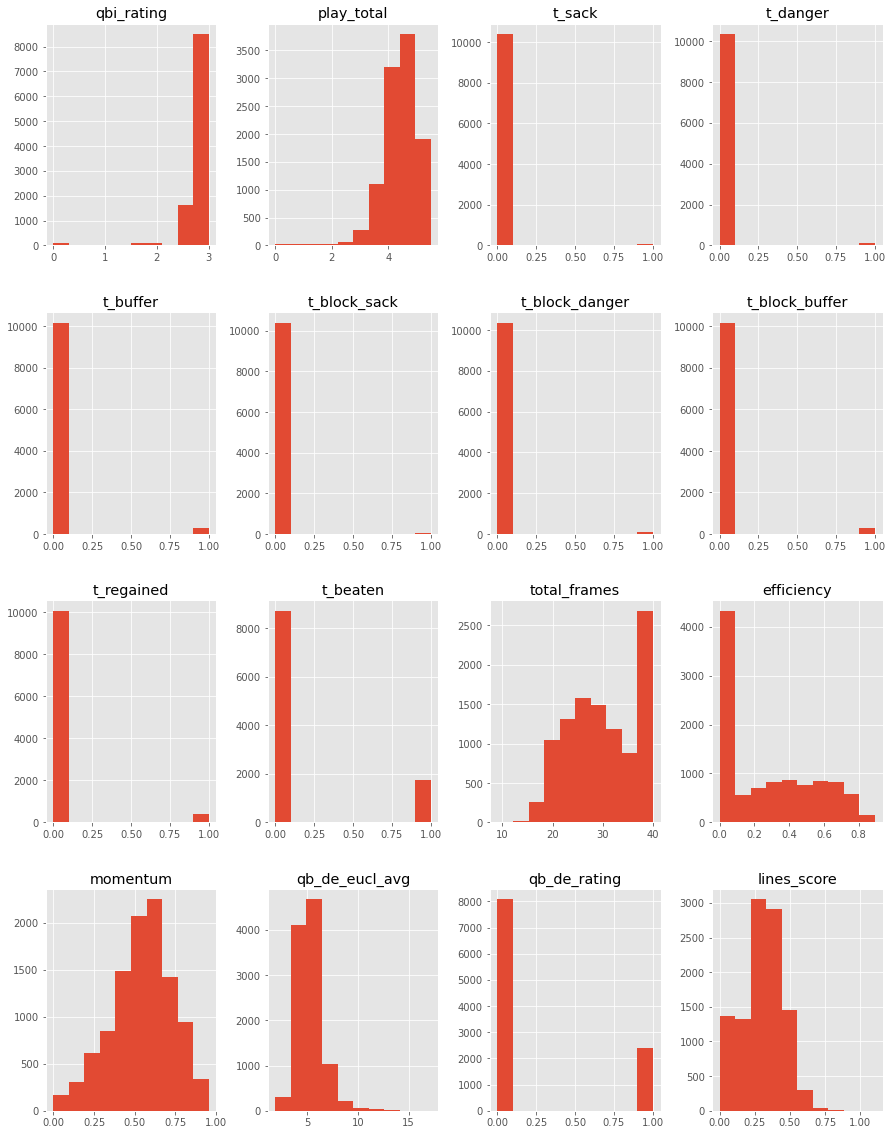

In [87]:
sql_xg = "select  * from play_results "
# select AVG(gr.t_qbi) as cost, COUNT(pr.playId), pr.total_frames, gr.* from game_results as gr, play_results as pr where gr.gameId = pr.gameId AND pr.total_frames >= 35 GROUP BY gr.gameId ORDER BY cost DESC 
df_qbi = pd.read_sql_query(sql_xg, con)
print("model len ",len(df_qbi))
#with pd.option_context('display.max_rows', None,):
#display(df_qbi)
fig = plt.figure(figsize = (15,20))
ax = fig.gca()
df_model = df_qbi
#target qbi_rating

df_model= df_qbi[['qbi_rating', 'play_total', 't_sack', 't_danger', 't_buffer', 't_block_sack', 't_block_danger', 't_block_buffer', 't_regained', 't_beaten', 'total_frames', 'efficiency', 'momentum', 'qb_de_eucl_avg', 'qb_de_rating', 'lines_score']] 
df_model.hist(ax = ax)

fig.savefig('features.png')

In [88]:


df_model['qbi_rating'].replace([0.0, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0, 2.25, 2.5, 2.75, 3.0],
                        [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11], inplace=True)


/opt/conda/lib/python3.7/site-packages/pandas/core/generic.py:6619: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


In [89]:

print(len(df_model))

attributes=['play_total', 't_sack', 't_danger', 't_buffer', 't_block_sack', 't_block_danger', 't_block_buffer', 't_regained', 't_beaten', 'total_frames', 'efficiency', 'momentum', 'qb_de_eucl_avg', 'qb_de_rating', 'lines_score'] 
X = df_model.drop(['qbi_rating'],axis=1)
X = df_model[attributes]
y = df_model["qbi_rating"]

print("X data head")
print(X.head())
print ("Y data head")
print(y.head())

10457
X data head
   play_total  t_sack  t_danger  t_buffer  t_block_sack  t_block_danger  \
0         4.5       0         0         0             0               0   
1         4.5       0         0         0             0               0   
2         3.5       0         0         0             0               0   
3         4.0       0         0         0             0               0   
4         4.5       0         0         0             0               0   

   t_block_buffer  t_regained  t_beaten  total_frames  efficiency  momentum  \
0               0           0         0            33    0.277778  0.722222   
1               0           0         0            26    0.307692  0.615385   
2               0           0         0            35    0.000000  0.850000   
3               0           0         1            28    0.368421  0.368421   
4               0           0         0            25    0.545455  0.636364   

   qb_de_eucl_avg  qb_de_rating  lines_score  
0        

In [90]:
# Train, Test, Split note this one is with randomness in the selection of samples
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, random_state=1)

In [91]:
import time
start_time = time.time()
print(start_time)

xgbc = XGBClassifier(max_depth=3, #how many levels of tree to grow, higher the num greater chance of overfitting
                     subsample = 0.5, #fraction of observations to be randomly sampled for each tree
                     n_estimators=200,
                     objective = "binary:logistic",
                     eval_metric=['merror','mlogloss'],
                     learning_rate=0.1, #alias of eta hyperparam, the step size shrinkage used in update to prevent overfit should be .01-.2
                     min_child_weight=1, #min sum of weights of all obs rquired in a child, high val can lead to underfitting, tune using CV
                     reg_alpha=0, #L! loss func regularization term on weights. higher more conservative the model
                     reg_lambda=1 #L2 loss func regularization term on weights, higher more conservative the model
                     )
print(xgbc)

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train = le.fit_transform(y_train)

xgbc.fit(X_train, y_train)
y_predict = xgbc.predict(X_test)
y_train_predict = xgbc.predict(X_train)

1673006168.6321895
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=['merror', 'mlogloss'],
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=1, missing=nan,
              monotone_constraints=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=None,
              reg_alpha=0, reg_lambda=1, ...)


In [92]:
ypred = xgbc.predict(X_test)
cm = confusion_matrix(y_test,ypred)
print(cm)

print('train accuracy', accuracy_score(y_train, y_train_predict))
print('test accuracy', accuracy_score(y_test, ypred))

[[  20    0    0    0    0    0    0    0    0    0    0    0]
 [   1    0    0    0    0    0    0    0    0    0    0    0]
 [   1    0    0    3    0    0    0    0    1    0    0    0]
 [   1    0    0    4    0    0    0    0    0    0    0    0]
 [   0    0    0    0    2    0    1    0    1    0    0    0]
 [   0    0    0    0    0   16    0    0    0    0    0    0]
 [   0    0    0    0    0    0    8    0    2    0    0    0]
 [   0    0    0    0    0    1    0   31    0    1    0    0]
 [   0    0    0    0    0    0    0    0    5    1    1    0]
 [   0    0    0    0    0    0    0    0    0  570    0    0]
 [   0    0    0    0    0    0    0    0    0    0  102    0]
 [   0    0    0    0    0    0    0    0    0    0    0 2887]]
train accuracy 0.9997057525378844
test accuracy 0.9959016393442623


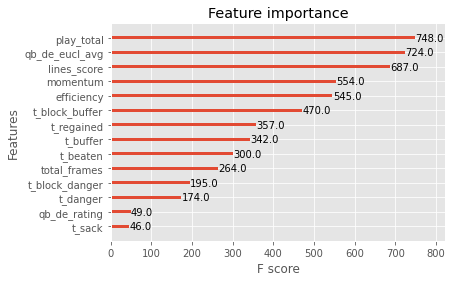

<Figure size 432x288 with 0 Axes>

In [93]:
plot_importance(xgbc)
pyplot.show()
pyplot.savefig('features_importance.png')
